In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls(), (path/'train').ls()

((#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')],
 (#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')])

In [ ]:
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]])

<Axes: >

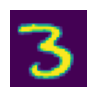

In [ ]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3)

In [ ]:
im3_t = tensor(im3)
im3_t[0:3, 0:3] * top_edge

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [ ]:
(im3_t[0:3, 0:3] * top_edge).sum()

tensor(0)

In [ ]:
df = pd.DataFrame(im3_t[:10, :20])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Grays')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [ ]:
(im3_t[4:7, 6:9] * top_edge).sum(), (im3_t[7:10, 17:20] * top_edge).sum(), 

(tensor(762), tensor(-29))

In [ ]:
def applay_kernel(row, col, kernel):

    #print(f"{row} {col} : {im3_t[row-1:row+2, col-1:col+2].shape}")
    return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

applay_kernel(5, 7, top_edge)

tensor(762)

In [ ]:
[[(i, j) for j in range(1,4)] for i in range(1, 4)]

[[(1, 1), (1, 2), (1, 3)], [(2, 1), (2, 2), (2, 3)], [(3, 1), (3, 2), (3, 3)]]

In [ ]:
rng = range(1, 27)
im_n = [[applay_kernel(i , j, top_edge) for j in rng] for i in rng]

<Axes: >

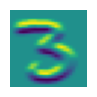

In [ ]:
show_image(im_n)

<Axes: >

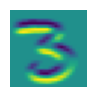

In [ ]:
buttom_edge = tensor([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]])
im_n = [[applay_kernel(i , j, buttom_edge) for j in rng] for i in rng]
show_image(im_n)


In [ ]:
dig_edge1 = tensor([[0, -1, 1],
                    [-1, 1, 0],
                    [1, 0, 0]])
dig_edge2 = tensor([[-1, 1, 0],
                    [0, 1, -1],
                    [0, 0, 1]])
kernels = torch.stack([top_edge, buttom_edge, dig_edge1, dig_edge2])

In [ ]:
kernels.shape

torch.Size([4, 3, 3])

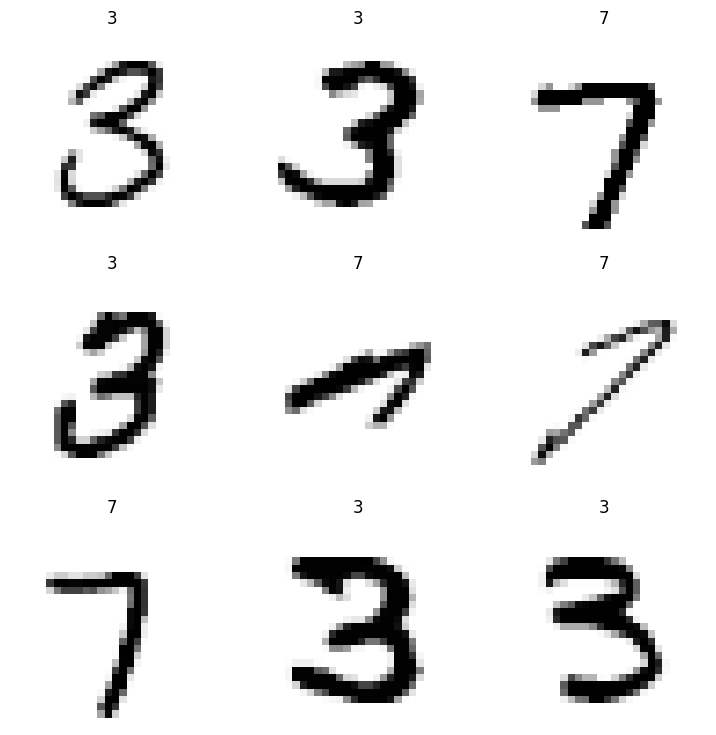

In [ ]:
mnist = DataBlock((ImageBlock(cls = PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)
dls = mnist.dataloaders(path)
dls.show_batch()

In [ ]:
xb, yb = dls.one_batch()
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
xb, yb = to_cpu(xb), to_cpu(yb)

In [ ]:
kernels.unsqueeze_(1).shape

torch.Size([4, 1, 3, 3])

In [ ]:
xb.dtype, kernels.dtype

(torch.float32, torch.int64)

In [ ]:
batch_features = F.conv2d(xb, kernels.float())
batch_features.shape

torch.Size([64, 4, 26, 26])

[<Axes: >, <Axes: >, <Axes: >, <Axes: >]

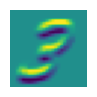

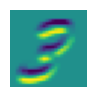

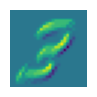

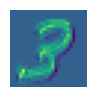

In [ ]:
[show_image(batch_features[0,i]) for i in range(4)]

In [ ]:
broken_cnn = sequential(
    nn.Conv2d(1, 30, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3,)
)
broken_cnn(xb).shape

torch.Size([64, 1, 26, 26])

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2 )
    if act: 
        res = nn.Sequential(res, nn.ReLU())
    
    return res

In [ ]:
simple_cnn = sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 32),
    conv(32, 2, act=False),
    Flatten()
)

In [ ]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [ ]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [ ]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.069092,0.057958,0.983808,00:12
1,0.026692,0.031100,0.991168,00:09


In [ ]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [ ]:
m[0].weight.shape, m[0].bias.shape

(torch.Size([4, 1, 3, 3]), torch.Size([4]))

In [ ]:
m = learn.model[1]
m, m[0].weight.shape, m[0].bias.shape

(Sequential(
   (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 torch.Size([8, 4, 3, 3]),
 torch.Size([8]))

In [ ]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks = (ImageBlock(cls = PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training', 'testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

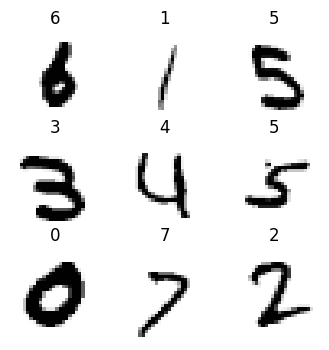

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

In [ ]:
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        Flatten()
    )

In [ ]:
from fastai.callback.hook import *
def fit(epochs = 1):
    learn = Learner(dls, simple_cnn(), loss_func=CrossEntropyLossFlat(),
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.306199,2.306021,0.113500,00:51


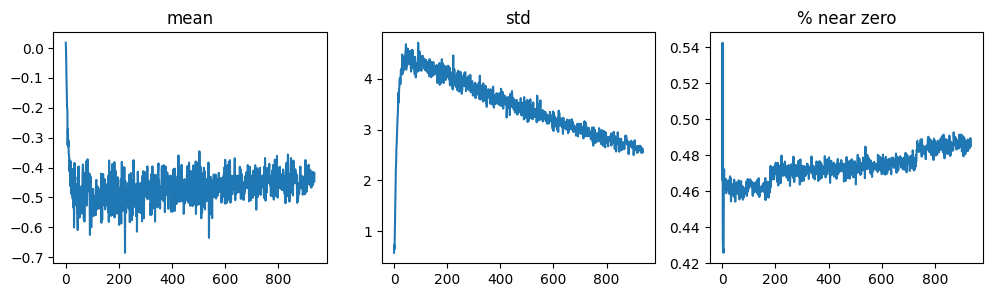

In [ ]:
learn.activation_stats.plot_layer_stats(0)

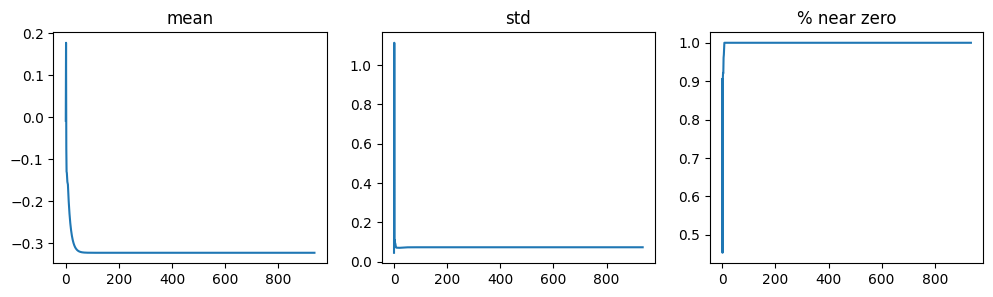

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [ ]:
dls = get_dls(512)
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.312479,2.303494,0.102800,00:49


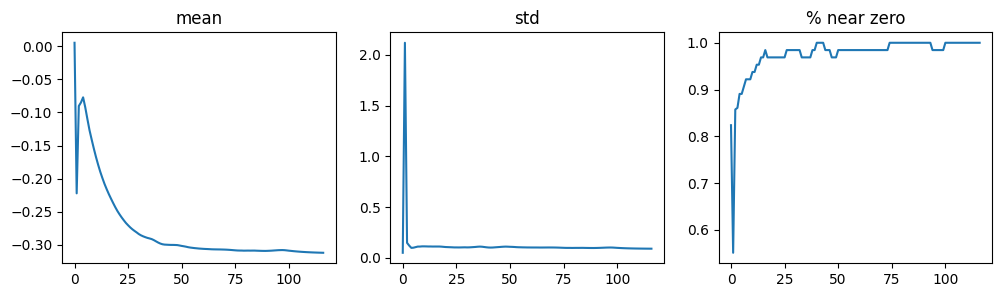

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [ ]:
def fit(epochs = 1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=CrossEntropyLossFlat(),
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.206788,0.073143,0.976200,00:41


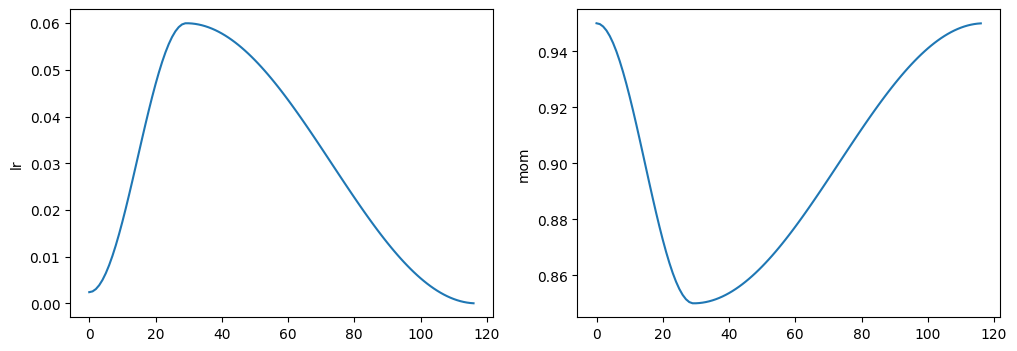

In [ ]:
learn.recorder.plot_sched()

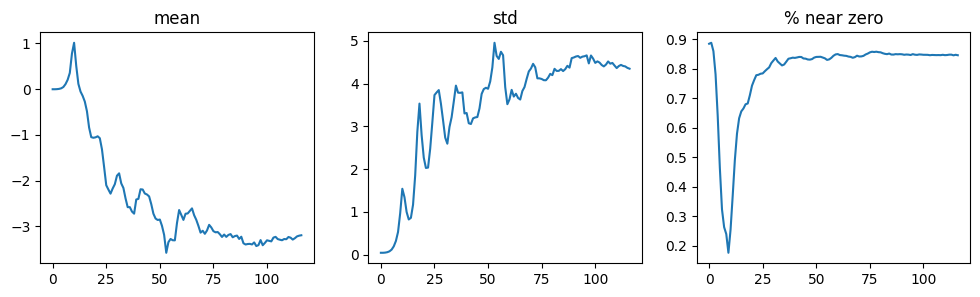

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

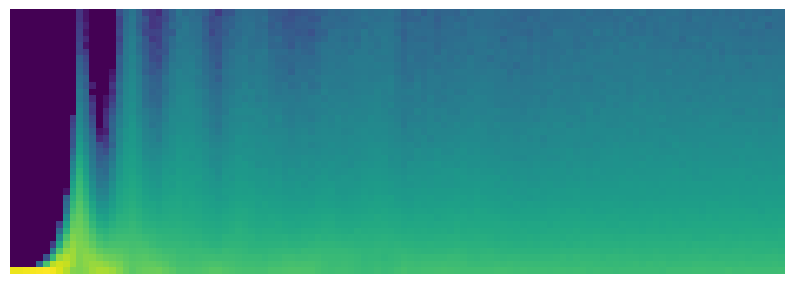

In [ ]:
learn.activation_stats.color_dim(-2)

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [ ]:
learn = fit()

/home/sagar/git/fastai/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.131857,0.057300,0.986100,00:39


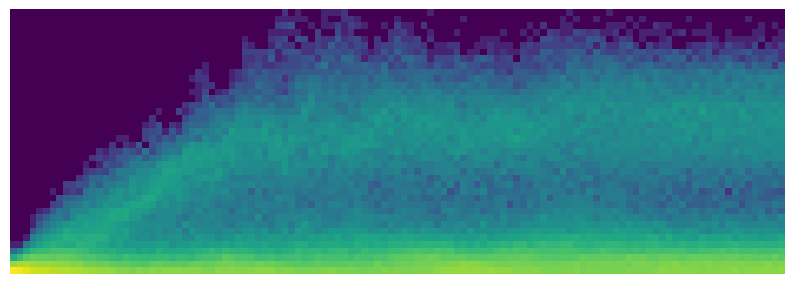

In [ ]:
learn.activation_stats.color_dim(-2)

In [ ]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.193584,0.118848,0.963500,00:37
1,0.081693,0.056017,0.981800,00:59
2,0.050066,0.054392,0.983900,00:52
3,0.031972,0.031866,0.989900,00:52
4,0.016049,0.024446,0.992100,00:52


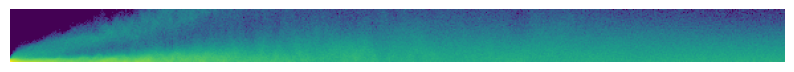

In [ ]:
learn.activation_stats.color_dim(-2)